In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
NEURAL_CONTROLLERS_DIR = os.environ['NEURAL_CONTROLLERS_DIR']
sys.path.append(NEURAL_CONTROLLERS_DIR)

In [9]:
import pickle
import os

methods = ['rfm', 'linear', 'logistic']
model_name = 'llama_3.3_70b_4bit_it'
source_ds = 'pubmedQA' #FinanceBench #RAGTruth #pubmedQA
# Initialize dictionaries to store validation and test results
d_val = {method: {} for method in methods}
d_test = {method: {} for method in methods}
trivial_metrics_val = []
trivial_metrics_test = []
selected_test_metrics = {method: [] for method in methods}

# Load data for each method
for method in methods:
    # Initialize lists to store results for each seed
    # Paths for validation and test metrics
    agg_path = f'{NEURAL_CONTROLLERS_DIR}/results/halubench_results/{source_ds}/{model_name}_{method}_aggregated_metrics.pkl'
    layer_path = f'{NEURAL_CONTROLLERS_DIR}/results/halubench_results/{source_ds}/{model_name}_{method}_best_layer_metrics.pkl'

    # print(path_val, path_test)
    # Check if files exist
    if not os.path.exists(agg_path):
        print(f"Validation file not found: {agg_path}")
        continue
    if not os.path.exists(layer_path):
        print(f"Test file not found: {layer_path}")
        continue
        
    # Load validation and test results
    with open(agg_path, 'rb') as f:
        agg_results = pickle.load(f)
    with open(layer_path, 'rb') as f:
        layer_results = pickle.load(f)

    print("="*100)
    print("Method: ", method)
    print("="*100)
    print("Aggregated metrics: ")
    for key, value in agg_results.items():
        print(f"{key}: {value}")
    print("="*100)
    print("Best layer metrics: ")
    for key, value in layer_results.items():
        print(f"{key}: {value}")
    print()


Method:  rfm
Aggregated metrics: 
auc: 0.9391039999999999
f1: 0.8864097363083164
Best layer metrics: 
auc: 0.9574919999999999
f1: 0.8940677966101694

Method:  linear
Aggregated metrics: 
auc: 0.9366
f1: 0.8795918367346939
Best layer metrics: 
auc: 0.960268
f1: 0.8951194184839044

Method:  logistic
Aggregated metrics: 
auc: 0.95304
f1: 0.8851774530271399
Best layer metrics: 
auc: 0.9531439999999999
f1: 0.8869565217391304



In [10]:
judge_types = ['llama', 'openai']
judge_models = ['llama_3.3_70b_4bit_it', 'gpt-4o']

# Iterate over seeds
for judge_type, judge_model in zip(judge_types, judge_models):
    accumulated_metrics = {}
    with open(f'{NEURAL_CONTROLLERS_DIR}/results/halubench_results/{source_ds}/{judge_type}_{judge_model}_metrics.pkl', 'rb') as f:
        results = pickle.load(f)

    print("-" * 30)
    print("Judge: {} {}".format(judge_model, judge_type))
    for metric, value in results.items():
        print(f"{metric}: {value}")


------------------------------
Judge: llama_3.3_70b_4bit_it llama
auc: 0.943872
f1: 0.8898128898128899
------------------------------
Judge: gpt-4o openai
auc: 0.956534
f1: 0.8987341772151899


# Random seeds

## Llama 3.3 70B 4bit

In [16]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of seeds and methods
seeds = np.arange(5)
methods = ['rfm', 'linear', 'logistic']
model_name = 'llama_3.3_70b_4bit'
source_ds = 'FinanceBench'
# Initialize dictionaries to store validation and test results
d_val = {method: {} for method in methods}
d_test = {method: {} for method in methods}
trivial_metrics_val = []
trivial_metrics_test = []
selected_test_metrics = {method: [] for method in methods}

hal_type = 'general'
# Load data for each method
for method in methods:
    # Initialize lists to store results for each seed
    for s in seeds:
        # Paths for validation and test metrics
        path_val = f'{NEURAL_CONTROLLERS_DIR}/results/halubench_results/{source_ds}/{model_name}_it_{method}_seed_{s}_{source_ds}_val_metrics.pkl'
        path_test = f'{NEURAL_CONTROLLERS_DIR}/results/halubench_results/{source_ds}/{model_name}_it_{method}_seed_{s}_{source_ds}_test_metrics.pkl'
        
        # print(path_val, path_test)
        # Check if files exist
        if not os.path.exists(path_val):
            print(f"Validation file not found: {path_val}")
            continue
        if not os.path.exists(path_test):
            print(f"Test file not found: {path_test}")
            continue
            
        # Load validation and test results
        with open(path_val, 'rb') as f:
            val_results = pickle.load(f)
        with open(path_test, 'rb') as f:
            test_results = pickle.load(f)
        
        # Get layer keys (excluding any non-layer keys)
        layers_val = [k for k in val_results.keys() if isinstance(val_results[k], dict)]
        layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
        
        # Store trivial metrics if they exist
        if 'trivial_metrics' in val_results:
            trivial_metrics_val.append(val_results['trivial_metrics'])
        if 'trivial_metrics' in test_results:
            trivial_metrics_test.append(test_results['trivial_metrics'])
        
        # Collect per-layer metrics for validation
        for key in layers_val:
            if key not in d_val[method]:
                d_val[method][key] = []
            d_val[method][key].append(val_results[key])
        
        # Collect per-layer metrics for test
        for key in layers_test:
            if key not in d_test[method]:
                d_test[method][key] = []
            d_test[method][key].append(test_results[key])
        
        # Identify the layer with the highest validation accuracy
        if layers_val:  # Check if there are any layers
            best_layer = max(layers_val, key=lambda x: val_results[x]['acc'])
            best_test_metrics = test_results.get(best_layer, {})
            
            # Store all metrics for the selected test layer
            selected_test_metrics[method].append(best_test_metrics)

# Compute average and standard deviation of selected test metrics
average_selected_test_metrics = {}
std_selected_test_metrics = {}
for method in methods:
    test_metrics_list = selected_test_metrics[method]
    if test_metrics_list:
        # Initialize dict for each metric
        metrics_dict = {}
        for metric in test_metrics_list[0].keys():  # Assuming all dicts have same metrics
            values = [metrics[metric] for metrics in test_metrics_list]
            metrics_dict[metric] = {
                'mean': np.mean(values),
                'std': np.std(values)
            }
        average_selected_test_metrics[method] = metrics_dict
    else:
        average_selected_test_metrics[method] = {}

# Print all metrics for each method
print("\nSingle best layer:")
for method in methods:
    print(f"\n{method.upper()}:")
    metrics_dict = average_selected_test_metrics[method]
    for metric, values in metrics_dict.items():
        print(f"{metric}: {values['mean']:.4f} ± {values['std']:.4f}")

Validation file not found: /u/dbeaglehole/neural_controllers/results/halubench_results/FinanceBench/llama_3.3_70b_4bit_it_logistic_seed_4_FinanceBench_val_metrics.pkl

Single best layer:

RFM:
acc: 64.2000 ± 2.7313
precision: 0.6236 ± 0.0556
recall: 0.6252 ± 0.0445
f1: 0.6214 ± 0.0259
auc: 0.6846 ± 0.0367
mse: 0.2242 ± 0.0109

LINEAR:
acc: 64.0000 ± 3.0496
precision: 0.6108 ± 0.0393
recall: 0.6528 ± 0.0715
f1: 0.6290 ± 0.0418
auc: 0.7144 ± 0.0411
mse: 0.2148 ± 0.0128

LOGISTIC:
acc: 67.1250 ± 2.8367
precision: 0.7972 ± 0.0365
recall: 0.3870 ± 0.0628
f1: 0.5184 ± 0.0622
auc: 0.7734 ± 0.0141
mse: 0.9438 ± 0.2922


In [17]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of methods
methods = ['linear', 'rfm', 'logistic']#, 'rfm_linear', 'linear_rfm']

# Initialize dictionaries to store results
d = {method: {} for method in methods}
trivial_accs = []

# Initialize dictionary to store agg results
aggs_over_seeds = {method: [] for method in methods}

# Load data for each method
for method in methods:    
    for s in seeds:
        path = f'{NEURAL_CONTROLLERS_DIR}/results/halubench_results/{source_ds}/{model_name}_it_{method}_seed_{s}_{source_ds}_test_metrics.pkl'
        
        # Check if file exists
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
            
        with open(path, 'rb') as f:
            results = pickle.load(f)
            
        # Store trivial accuracy if it exists
        if 'trivial_acc' in results:
            trivial_accs.append(results['trivial_acc'])
        
        # Store linear_agg results - store the entire dictionary
        if 'aggregation' in results:
            aggs_over_seeds[method].append(results['aggregation'])

# Compute and print metrics
print("\nAggregated Over layers:")
for method in methods:
    print(f"\n{method.upper()}:")
    
    # Calculate and print metrics for all entries in linear_agg
    if aggs_over_seeds[method]:
        # Get all metric keys from the first result
        metric_keys = aggs_over_seeds[method][0].keys()
        
        for metric in metric_keys:
            # Extract this metric from all seeds
            values = [result[metric] for result in aggs_over_seeds[method]]
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric}: {mean:.4f} ± {std:.4f}")

File not found: /u/dbeaglehole/neural_controllers/results/halubench_results/FinanceBench/llama_3.3_70b_4bit_it_logistic_seed_4_FinanceBench_test_metrics.pkl

Aggregated Over layers:

LINEAR:
acc: 60.6000 ± 3.3971
precision: 0.5756 ± 0.0376
recall: 0.6401 ± 0.0387
f1: 0.6047 ± 0.0251
auc: 0.6308 ± 0.0565
mse: 0.5419 ± 0.0722

RFM:
acc: 67.1000 ± 3.7336
precision: 0.6350 ± 0.0458
recall: 0.7126 ± 0.0642
f1: 0.6701 ± 0.0432
auc: 0.7182 ± 0.0475
mse: 0.2300 ± 0.0248

LOGISTIC:
acc: 68.0000 ± 1.8371
precision: 0.7457 ± 0.0479
recall: 0.4887 ± 0.1273
f1: 0.5767 ± 0.0672
auc: 0.7654 ± 0.0161
mse: 1.5860 ± 1.1293


## Judge models

In [ ]:

seeds = np.arange(5)
hal_type = 'general'
judge_types = ['llama', 'openai']
judge_models = ['llama_3.3_70b_4bit_it', 'gpt-4o']

# Iterate over seeds
for judge_type, judge_model in zip(judge_types, judge_models):
    accumulated_metrics = {}
    for seed in seeds:
        with open(f'{NEURAL_CONTROLLERS_DIR}/results/halu_eval_results/{judge_type}_{judge_model}_{hal_type}_seed_{seed}_metrics.pkl', 'rb') as f:
            llama_results = pickle.load(f)
            
            # Initialize accumulated_metrics with the first seed's metrics
            if not accumulated_metrics:
                accumulated_metrics = {metric: [] for metric in llama_results.keys()}
                
            # Accumulate metrics for each seed
            for metric, val in llama_results.items():
                accumulated_metrics[metric].append(val)

    # Calculate and print averages
    print('-' * 30)
    print('{} {} (averaged over seeds)'.format(judge_model, judge_type))
    print('-' * 30)
    for metric, values in accumulated_metrics.items():
        mean_val = np.mean(values)
        std_val = np.std(values)
        print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")


------------------------------
llama_3.3_70b_4bit_it llama (averaged over seeds)
------------------------------
acc: 79.4410 ± 0.5209
precision: 0.3756 ± 0.0136
recall: 0.2151 ± 0.0101
f1: 0.2735 ± 0.0113
auc: 0.6338 ± 0.0116
mse: 0.1981 ± 0.0051
------------------------------
gpt-4o openai (averaged over seeds)
------------------------------
acc: 72.3425 ± 0.6831
precision: 0.2700 ± 0.0141
recall: 0.3147 ± 0.0145
f1: 0.2905 ± 0.0134
auc: 0.6175 ± 0.0129
mse: 0.2364 ± 0.0066


## Layer-wise plots

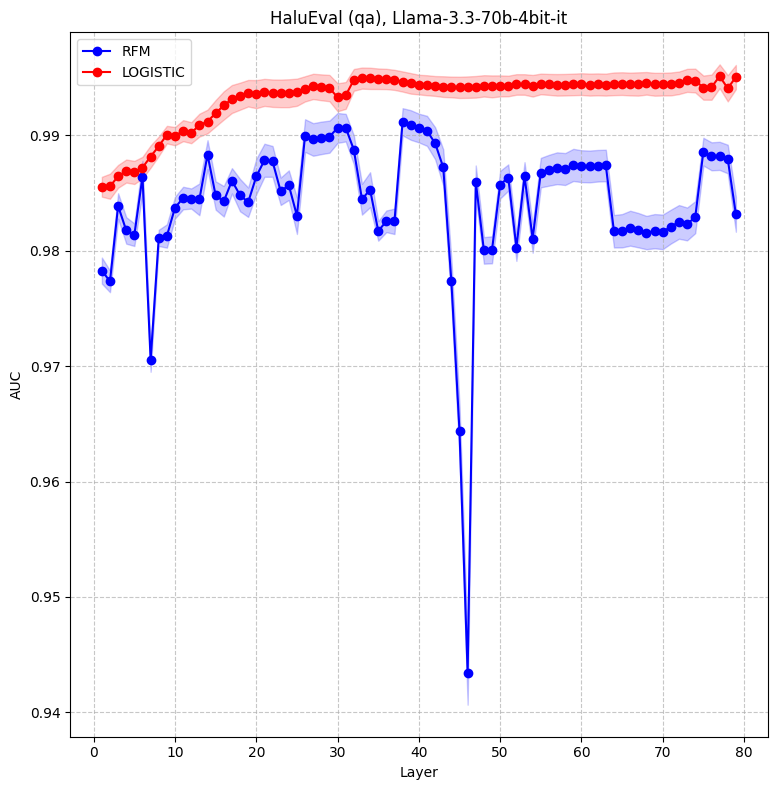

In [17]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of seeds
seeds = np.arange(5)
methods = ['rfm', 'logistic']
models = ['llama_3.3_70b_4bit_it']
metric = 'auc'
# Initialize dictionaries to store results
all_results = {}
hal_type = 'qa'
for model in models:
    all_results[model] = {
        'test': {method: {} for method in methods}
    }

    # Load data for each method
    for method in methods:
        # Process each seed
        for s in seeds:
            # Path for test metrics
            path_test = f'{NEURAL_CONTROLLERS_DIR}/results/halu_eval_results/{model}_{method}_seed_{s}_{hal_type}_test_metrics.pkl'
            
            # Check if file exists
            if not os.path.exists(path_test):
                print(f"File not found: {path_test}")
                continue
                
            # Load test results
            with open(path_test, 'rb') as f:
                test_results = pickle.load(f)
            
            # Get layer keys (excluding non-dict entries)
            layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
            
            # Collect per-layer metrics
            for key in layers_test:
                if key not in all_results[model]['test'][method]:
                    all_results[model]['test'][method][key] = []
                all_results[model]['test'][method][key].append(test_results[key][metric])

# Calculate average accuracies per layer
avg_results = {}
for model in models:
    avg_results[model] = {}
    for method in methods:
        avg_results[model][method] = {}
        for layer, accs in all_results[model]['test'][method].items():
            if accs:  # Check if we have data for this layer
                avg_results[model][method][layer] = {
                    'mean': np.mean(accs),
                    'std': np.std(accs)
                }


# Plot the results
plt.figure(figsize=(15, 8))

# Define colors and alpha values for shading
colors = {'rfm': 'blue', 'logistic': 'red'}
alpha_fill = 0.2  # Alpha transparency for the shaded region

for i, model in enumerate(models):
    plt.subplot(1, 2, i+1)
    
    for method in methods:
        layer_data = avg_results[model][method]
        if layer_data:
            # Sort layers by their numerical value
            layers = sorted([int(layer) for layer in layer_data.keys() if isinstance(layer, int)])
            
            # Extract mean and std for plotting
            means = [layer_data[layer]['mean'] for layer in layers if layer in layer_data]
            stds = [layer_data[layer]['std'] for layer in layers if layer in layer_data]
            
            # Center the layers
            layers = [x+len(layers)+1 for x in layers]

            # Plot the mean line
            plt.plot(layers, means, label=method.upper(), marker='o', color=colors[method])
            
            # Add shaded error region
            plt.fill_between(
                layers, 
                [m - s for m, s in zip(means, stds)],  # lower bound
                [m + s for m, s in zip(means, stds)],  # upper bound
                color=colors[method], 
                alpha=alpha_fill
            )
    
    model_str = model.replace("_", "-")
    model_str = model_str[0].upper() + model_str[1:]
    plt.title(f'HaluEval ({hal_type}), {model_str}')
    plt.xlabel('Layer')
    plt.ylabel(f'{metric.upper()}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

plt.savefig(f'plots/he_{hal_type}_test_{metric}_across_layers.pdf', format='pdf')
plt.show()